
# CAPSTONE PROJECT: Singapore Visitors Venue Recommendation

_______
## I. INTRODUCTION: Business Problem


Singapore is much more than the sum of its numerous attractions. It’s constantly evolving, reinventing, and reimagining itself, with people who are passionate about creating new possibilities. It’s where foodies, explorers, collectors, action seekers, culture shapers, and socialisers meet and create new experiences every day. Tourism is also a major industry and contributor to the Singaporean economy, attracting 18.5 million international tourists in 2018, more than 3 times of Singapore's total population. Singapore is the 5th most visited city in the world, and 2nd in the Asia-Pacific.
However, travelers often find themselves confused with what to eat, where to stay, places to visit etc.. Even websites recommend usual tourist attractions and places to stay based on simple keywords like "Hotels", "Best Food","Travel" etc

The goal of this project is to collect best visited/reviewed places using Foursquare API and provide an accurate recommendation. We will be utilizing data retrieved from Singapore open data sources and FourSquare API venue recommendations.

The recommender system in this notebook will provide the following use case scenario:
#### If a person is planning to visit Singapore as a Tourist and looking for a reasonable accommodation.
#### If the user wants to receive a venue recommendation where he can stay - places like Best Hotels or rent an apartment according to his budget with nearby places of interest or search category option.
#### With clear segemnting and cluster analysis I would like to present a comparison table of all possible town venues.

We will download the data from data.gov.sg and utilize the Median Rental  prices
* Singapore Median Rental Prices by town.
* Popular Food venues in the vicinity. (Sample category selection)

Note: While this demo makes use of Food Venue Category, Other possible categories can also be used for the same implementation such as checking categories like:
* Outdoors and Recreation
* Nightlife
* Nearby Schools, etc.

As FourSquare API only allows 50 free venue query I would like to limit the scope of this search.


## II. DATA ACQUISITION
We will use of the following data sources to make our recommendation:

#### Singapore Towns and median residential rental prices.
Data retrieved from Singapore open dataset from <a href='https://data.gov.sg/dataset/b35046dc-7428-4cff-968d-ef4c3e9e6c99'>median rent by town and flattype</a> from https://data.gov.sg website. 

The data source contains median rental prices of Singapore HDB units from 2005 up to 4th quarter of 2019. I will retrieve rental the most recent recorded rental prices from this data source (Q4 2019) being the most relevant price available at this time. For this project, I will simplify the analysis by using the average rental prices of all available flat type.

#### Singapore Top Venue Recommendations from FourSquare API
(FourSquare website: www.foursquare.com)

I will be using the FourSquare API to explore neighborhoods in selected towns in Singapore. The Foursquare explore function will be used to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters.  The following information are retrieved on the first query:
* Venue ID
* Venue Name
* Coordinates : Latitude and Longitude
* Category Name

Another venue query will be performed to retrieve venue ratings for each location. Note that rating information is a paid service from FourSquare and we are limited to only 50 queries per day. With this constraint, we limit the category analysis with only one type for this demo. I will try to retrieve as many ratings as possible for each retrieved venue ID.


## III. METHODOLOGY

#### Singapore Towns List with median residential rental prices.
The source data contains median rental prices of Singapore HDB units from 2005 up to 4th quarter of 2019.

**Data Cleanup and re-grouping.** The retrieved table contains some un-wanted entries and needs some cleanup.

The following tasks will be performed:
* Drop/ignore cells with missing data.
* Use most current data record.
* Fix data types.


#### Importing and Installing Required Libraries


In [1]:
!pip install folium
!pip install geopy
!pip install wget

     |████████████████████████████████| 92kB 18.5MB/s eta 0:00:01


In [265]:
import wget
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

import requests # library to handle requests
import lxml.html as lh
import bs4 as bs
import urllib.request

print('All Required Libraries Imported')

All Required Libraries Imported


In [266]:
import matplotlib.pyplot as plt
import seaborn as sns

In [267]:
from IPython.display import HTML
import base64

# Extra Helper scripts to generate download links for saved dataframes in csv format.
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

#### 1. Downloading Singapore towns list with and median residential rental prices

In [268]:
import zipfile
import os
!wget -q -O 'median-rent-by-town-and-flat-type.zip' "https://data.gov.sg/dataset/b35046dc-7428-4cff-968d-ef4c3e9e6c99/download"
zf = zipfile.ZipFile('./median-rent-by-town-and-flat-type.zip')
sgp_data = pd.read_csv(zf.open("median-rent-by-town-and-flat-type.csv"))
sgp_data.rename(columns = {'town':'Town'}, inplace = True)
sgp_data.head()
#sgp_median_rent_by_town_data

,quarter,Town,flat_type,median_rent
0,2005-Q2,ANG MO KIO,1-RM,na
1,2005-Q2,ANG MO KIO,2-RM,na
2,2005-Q2,ANG MO KIO,3-RM,800
3,2005-Q2,ANG MO KIO,4-RM,950
4,2005-Q2,ANG MO KIO,5-RM,-


In [269]:
sgp_data.tail()

,quarter,Town,flat_type,median_rent
9244,2019-Q4,YISHUN,2-RM,-
9245,2019-Q4,YISHUN,3-RM,1600
9246,2019-Q4,YISHUN,4-RM,1800
9247,2019-Q4,YISHUN,5-RM,2000
9248,2019-Q4,YISHUN,EXEC,2150


#### Data Cleanup and re-grouping.
The retrieved table contains some un-wanted entries and needs some cleanup.
The following tasks will be performed:
* Drop/ignore cells with missing data.
* Use most current data record.
* Fix data types.

In [270]:
# Drop rows with rental price == 'na'.
sgp_data_filter=sgp_data[~sgp_data['median_rent'].isin(['-','na'])]

# Take the most recent report which is "2019-Q4"
sgp_filter=sgp_data_filter[sgp_data_filter['quarter'] == "2019-Q4"]

# Now that all rows reports are "2019-Q4", we dont need this column anymore.
sgp_data_filter=sgp_data_filter.drop(['quarter'], axis=1)

# Ensure that median_rent column is float64.
sgp_data_filter['median_rent']=sgp_data_filter['median_rent'].astype(np.float64)

* Note: We can separate the analysis HDB unit size to be more accurate, For this demonstration however, We will do a simplier analysis by using a median price for all available rental units regardless of its size. 

In [271]:
singapore_average_rental_prices_by_town = sgp_data_filter.groupby(['Town'])['median_rent'].mean().reset_index()
singapore_average_rental_prices_by_town

,Town,median_rent
0,ANG MO KIO,1957.195122
1,BEDOK,1958.211055
2,BISHAN,2118.773006
3,BUKIT BATOK,1922.827225
4,BUKIT MERAH,2257.237288
5,BUKIT PANJANG,1852.586207
6,BUKIT TIMAH,1816.666667
7,CENTRAL,2400.706522
8,CHOA CHU KANG,1902.500000
9,CLEMENTI,2111.664516


* Adding geographical coordinates of each town location.

#### Retrieve town coordinates.
We will use Geocode library to retrive the coordinates (latitude and longitude of each town centers. For this exercise, I just used the MRT stations as the center points of each evaluated towns.
The town coordinates will be used in retrieval of Foursquare API location data. 

In [8]:
!pip install geocoder

     |████████████████████████████████| 102kB 7.3MB/s ta 0:00:011


In [272]:
singapore_average_rental_prices_by_town['Latitude'] = 0.0
singapore_average_rental_prices_by_town['Longitude'] = 0.0

In [273]:
geo = Nominatim(user_agent='pythonapi')
for idx,town in singapore_average_rental_prices_by_town['Town'].iteritems():
    coord = geo.geocode(town + ' ' + "Singapore", timeout = 10)
    if coord:
        singapore_average_rental_prices_by_town.loc[idx,'Latitude'] = coord.latitude
        singapore_average_rental_prices_by_town.loc[idx,'Longitude'] = coord.longitude
    else:
        singapore_average_rental_prices_by_town.loc[idx,'Latitude'] = NULL
        singapore_average_rental_prices_by_town.loc[idx,'Longitude'] = NULL

In [274]:
singapore_average_rental_prices_by_town.set_index("Town")

,median_rent,Latitude,Longitude
Town,,,
ANG MO KIO,1957.195122,1.370073,103.849516
BEDOK,1958.211055,1.323976,103.930216
BISHAN,2118.773006,1.351452,103.848250
BUKIT BATOK,1922.827225,1.349057,103.749591
BUKIT MERAH,2257.237288,1.280628,103.830591
BUKIT PANJANG,1852.586207,1.378629,103.762136
BUKIT TIMAH,1816.666667,1.354690,103.776372
CENTRAL,2400.706522,1.340863,103.830392
CHOA CHU KANG,1902.500000,1.384749,103.744534


#### Using Folium - Singapore basemap.

In [275]:
geo = Nominatim(user_agent='IBMNotebook')
address = 'Singapore'
location = geo.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore {}, {}.'.format(latitude, longitude))

# create map of Singapore using latitude and longitude values
map_singapore = folium.Map(location=[latitude, longitude],tiles="OpenStreetMap", zoom_start=11)

# add markers to map
for lat, lng, town in zip(
    singapore_average_rental_prices_by_town['Latitude'],
    singapore_average_rental_prices_by_town['Longitude'],
    singapore_average_rental_prices_by_town['Town']):
    label = town
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
        parse_html=False).add_to(map_singapore)
map_singapore

The geograpical coordinate of Singapore 1.357107, 103.8194992.


In [276]:
fileName = "singapore_average_rpbt.csv"
linkName = "Singapore Average Rental Prices"
create_download_link(singapore_average_rental_prices_by_town,linkName,fileName)

## IV. Performing Segmentation and Clustering Analysis in Singapore
### Retrieving FourSquare Places of interest.

We will be using the Foursquare API - **explore** function to get the most common venue categories in each neighborhood and then group the neighborhoods into clusters. 

We will use the *k*-means clustering algorithm for analysis.

Finally, the Folium library is used to visualize the recommended neighborhoods and their emerging clusters.

The function **getNearbyVenues** extracts the following information for the dataframe it generates:
* Venue ID
* Venue Name
* Coordinates : Latitude and Longitude
* Category Name

The function **getVenuesByCategory** performs the following:
  1. **category** based venue search to simulate user venue searches based on certain places of interest. This search extracts the following information:
   * Venue ID
   * Venue Name
   * Coordinates : Latitude and Longitude
   * Category Name
  2. For each retrieved **venueID**, retrive the venues category rating.

In [277]:
CLIENT_ID = 'VJ2W3CEK2NEOQKTYPWX03OAJE0ZOSFQVBHJTLUN35NC5B2BS' # your Foursquare ID
CLIENT_SECRET = 'LSBZQ0UATKRGWHQLR0OGTDSOPOHBVF5XN4WDK30WWWTE53AE' # your Foursquare Secret
VERSION = '20200410' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VJ2W3CEK2NEOQKTYPWX03OAJE0ZOSFQVBHJTLUN35NC5B2BS
CLIENT_SECRET:LSBZQ0UATKRGWHQLR0OGTDSOPOHBVF5XN4WDK30WWWTE53AE


In [278]:
LIMIT = 50

## 1. Exploring Neighbourhood  in Singapore
#### Using the following foursquare api query url, search venues on all boroughs in selected Singapore towns.
> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

Retrieving data from FourSquare API is not so straight forward. It returns a json list top venues to visit to city. The scores however, is retrieved on a separate query to the FourSquare Venue API and is limited to 50 queries per day when using a free FourSquare subscription.<br/> The following functions generates the query urls and processes the returned json data into dataframe.
<br/><br/>
The function **getNearbyVenues** extracts the following information for the dataframe it generates:
* Venue ID
* Venue Name
* Coordinates : Latitude and Longitude
* Category Name

The function **getVenuesByCategory** performs the following:
  1. **category** based venue search to simulate user venue searches based on certain places of interest. This search extracts the following information:
   * Venue ID
   * Venue Name
   * Coordinates : Latitude and Longitude
   * Category Name
  2. For each retrieved **venueID**, retrive the venues category rating.

The generated data frame in the second function contains the following column:
<TABLE align='left'>
    <tr>
        <th>Column Name</th><th>Description</th>
    </tr>
<tr><td>Town</td><td>Town Name</td></tr>
<tr><td>Town Latitude</td><td>Towns MRT station Latitude</td></tr>
<tr><td>Town Longitude</td><td>Town MRT station Latitude</td></tr>
<tr><td>VenueID</td><td>FourSquare Venue ID</td></tr>
<tr><td>VenueName</td><td>Venue Name</td></tr>
<tr><td>score</td><td>FourSquare Venue user rating</td></tr>
<tr><td>category</td><td>Category group name</td></tr>
<tr><td>catID</td><td>Category ID</td></tr>
<tr><td>latitude</td><td>Venue Location - latitude</td></tr>
<tr><td>longitude</td><td>Venue Location - longitude</td></tr>


#### getNearbyVenue Function

In [279]:
import time
# ---------------------------------------------
# The following function retrieves the venues given the names and coordinates and stores it into dataframe.
FOURSQUARE_EXPLORE_URL = 'https://api.foursquare.com/v2/venues/explore?'
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('getNearbyVenues',names)
        # create the API request URL
        url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOURSQUARE_EXPLORE_URL,CLIENT_ID,CLIENT_SECRET,VERSION,
            lat,lng,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,lat,lng, 
            v['venue']['id'],v['venue']['name'], 
            v['venue']['location']['lat'],v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        time.sleep(2)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town','Town Latitude','Town Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    
    return(nearby_venues)

#### getVenuesByCategory Function

In [280]:
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'
# SEARCH VENUES BY CATEGORY

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesByCategory(names, latitudes, longitudes, categoryID, radius=500):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    venue_columns = ['Town','Town Latitude','Town Longitude','VenueID','VenueName','score','category','catID','latitude','longitude']
    venue_DF = pd.DataFrame(columns=venue_columns)
    print("[#Start getVenuesByCategory]")
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name,",",end='')
        #print('getVenuesByCategory',categoryID,name) ; # DEBUG: be quiet
        # create the API request URL
        url = '{}client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            FOURSQUARE_SEARCH_URL,CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT,categoryID)
        # make the GET request
        results = requests.get(url).json()
        # Populate dataframe with the category venue results
        # Extracting JSON  data values
        
        for jsonSub in results['response']['venues']:
            #print(jsonSub)
            # JSON Results may not be in expected format or incomplete data, in that case, skip!
            ven_id = 0
            try:
                # If there are any issue with a restaurant, retry or ignore and continue
                # Get location details
                ven_id   = jsonSub['id']
                ven_cat  = jsonSub['categories'][0]['pluralName']
                ven_CID  = jsonSub['categories'][0]['id']
                ven_name = jsonSub['name']
                ven_lat  = jsonSub['location']['lat']
                ven_lng  = jsonSub['location']['lng']
                venue_DF = venue_DF.append({
                    'Town'      : name,
                    'Town Latitude' : lat,
                    'Town Longitude': lng,
                    'VenueID'   : ven_id,
                    'VenueName' : ven_name,
                    'score'     : 'nan',
                    'category'  : ven_cat,
                    'catID'     : ven_CID,
                    'latitude'  : ven_lat,
                    'longitude' : ven_lng}, ignore_index=True)
            except:
                continue
    # END OF LOOP, return.
    print("\n[#Done getVenuesByCategory]")
    return(venue_DF)

#### getVenuesIDScore Function

In [281]:
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'
# SEARCH VENUES BY CATEGORY

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID','Score']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesIDScore(venueID):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    global venue_id_recover
    print("[getVenuesIDScore]")
    venID_URL = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueID,CLIENT_ID,CLIENT_SECRET,VERSION)
    print(venID_URL)
    venID_score = 0.00
    # Process results
    try:
        venID_result = requests.get(venID_URL).json()
        venID_score  = venID_result['response']['venue']['rating']
    except: 
        venue_id_recover = venue_id_recover.append({'VenueID' : venueID, 'Score' : 0.0})
        return ["error",0.0]
    return ["success",venID_score]

In [282]:
singapore_average_rental_prices_by_town.dtypes

Town            object
median_rent    float64
Latitude       float64
Longitude      float64
dtype: object

In [283]:
venue_columns = ['Town','Town Latitude','Town Longitude','VenueID','VenueName','score','category','catID','latitude','longitude']
singapore_town_venues = pd.DataFrame(columns=venue_columns)

#### Search Venues with recommendations on  : Food Venues (Restaurants,Fastfoods, etc.)

To demonstrate user selection of places of interest, We will use this Food Venues category in our further analysis.
* This Foursquare search is expected to collect venues in the following category:
 * category
 * Food Courts
 * Coffee Shops
 * Restaurants
 * Cafés
 * Other food venues

In [284]:
singapore_town_venues.head()

,Town,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude


In [285]:
# Town Venues : Restaurants, Fastfoods, Etc
# For testing
if False:
    categoryID = "4d4b7105d754a06377d81259"
    town_names = ['ANG MO KIO']
    lat_list   = [1.370073]
    lng_list   = [103.849516]
    tmp = getVenuesByCategory(names=town_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)
    singapore_town_venues = pd.concat([singapore_town_venues,tmp], ignore_index=True)

In [286]:
singapore_town_venues.head()

,Town,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude


In [287]:
# Food Venues : Restaurants, Fastfoods, Etc
categoryID = "4d4b7105d754a06374d81259"
town_names = singapore_average_rental_prices_by_town['Town']
lat_list   = singapore_average_rental_prices_by_town['Latitude']
lng_list   = singapore_average_rental_prices_by_town['Longitude']
singapore_food_venues = getVenuesByCategory(names=town_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)

[#Start getVenuesByCategory]
ANG MO KIO ,BEDOK ,BISHAN ,BUKIT BATOK ,BUKIT MERAH ,BUKIT PANJANG ,BUKIT TIMAH ,CENTRAL ,CHOA CHU KANG ,CLEMENTI ,GEYLANG ,HOUGANG ,JURONG EAST ,JURONG WEST ,KALLANG/WHAMPOA ,MARINE PARADE ,PASIR RIS ,PUNGGOL ,QUEENSTOWN ,SEMBAWANG ,SENGKANG ,SERANGOON ,TAMPINES ,TOA PAYOH ,WOODLANDS ,YISHUN ,
[#Done getVenuesByCategory]


* Saving collected Singapore food venues by town into csv for future use.

In [288]:
# Save collected Singapore food venues by town into csv for future use.
fileName = "singapore_food_venues.Category.csv"
linkName = "Singapore_food_venues_Category.csv"
create_download_link(singapore_food_venues,linkName,fileName)

#### Search Venues with recommendations on  : Outdoors and Recreation
Note: 
* 2nd Test: Retrieve venues for Outdoors and Recreation.
* This section can be ran separately due to maximum limit encountered when using Foursquare free API version. I have saved simmilar results in github to run the same analyis.

In [289]:
# Disable for this run demo.
#if False:
    # Outdoors & Recreation, 
    categoryID = "4d4b7105d754a06377d81259"
    town_names = singapore_average_rental_prices_by_town['Town']
    lat_list   = singapore_average_rental_prices_by_town['Latitude']
    lng_list   = singapore_average_rental_prices_by_town['Longitude']
    singapore_outdoor_venues_by_town = getVenuesByCategory(names=town_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)
    # Save collected Singapore Outdoors & Recreation venues by town into csv for future use.
    # singapore_outdoor_venues_by_town.to_csv('singapore_outdoorAndRecration.Category.csv',index=False)
    fileName = "singapore_outdoorAndRecration.Category.csv"
    linkName = "Singapore_outdoorAndRecration.Category.csv"
    create_download_link(singapore_food_venues,linkName,fileName)

[#Start getVenuesByCategory]
ANG MO KIO ,BEDOK ,BISHAN ,BUKIT BATOK ,BUKIT MERAH ,BUKIT PANJANG ,BUKIT TIMAH ,CENTRAL ,CHOA CHU KANG ,CLEMENTI ,GEYLANG ,HOUGANG ,JURONG EAST ,JURONG WEST ,KALLANG/WHAMPOA ,MARINE PARADE ,PASIR RIS ,PUNGGOL ,QUEENSTOWN ,SEMBAWANG ,SENGKANG ,SERANGOON ,TAMPINES ,TOA PAYOH ,WOODLANDS ,YISHUN ,
[#Done getVenuesByCategory]


In [290]:
singapore_outdoor_venues_by_town.head()

,Town,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude
0,ANG MO KIO,1.370073,103.849516,4b8ee650f964a520843d33e3,Ang Mo Kio Bus Interchange,nan,Bus Stations,4bf58dd8d48988d1fe931735,1.369284,103.848903
1,ANG MO KIO,1.370073,103.849516,4b08bbdbf964a5209a1123e3,Fitness First,nan,Gyms or Fitness Centers,4bf58dd8d48988d175941735,1.369249,103.848584
2,ANG MO KIO,1.370073,103.849516,51f77455498e868c8f2bbbbb,True Fitness,nan,Gyms,4bf58dd8d48988d176941735,1.372891,103.847661
3,ANG MO KIO,1.370073,103.849516,4c82e4a747cc224bc0c48a9f,Ang Mo Kio Town Garden East,nan,Gardens,4bf58dd8d48988d15a941735,1.369448,103.850767
4,ANG MO KIO,1.370073,103.849516,549013ff498e19833e0af35b,Aerobics Studio @ True Fitness,nan,Gyms,4bf58dd8d48988d176941735,1.372866,103.847711


#### Search Venues with recommendations on  : Singapore NightLife
Note: 
* 3nd Test: Retrieve venues for Outdoors and Recreation venues that are accessible at night. This includes places like NightClubs, Bars and places of interest operating 24 hours.
* This section can be ran separately due to maximum limit encountered when using Foursquare free API version. I have saved simmilar results in github to run the same analyis.

In [291]:
# Disable for this run demo.
#if False:

    #Nightlife Spot = 4d4b7105d754a06376d81259
    categoryID = "4d4b7105d754a06376d81259"
    town_names = singapore_average_rental_prices_by_town['Town']
    lat_list   = singapore_average_rental_prices_by_town['Latitude']
    lng_list   = singapore_average_rental_prices_by_town['Longitude']
    singapore_Nightlife_by_town = getVenuesByCategory(names=town_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID) 
    
    # Save collected Singapore Outdoors & Recreation venues by town into csv for future use.
    # singapore_outdoor_venues_by_town.to_csv('singapore_outdoorAndRecration.Category.csv',index=False)
    fileName = "singapore_Nightlife_by_town.Category.csv"
    linkName = "Singapore_Nightlife_by_town.Category.csv"
    create_download_link(singapore_Nightlife_by_town,linkName,fileName)

[#Start getVenuesByCategory]
ANG MO KIO ,BEDOK ,BISHAN ,BUKIT BATOK ,BUKIT MERAH ,BUKIT PANJANG ,BUKIT TIMAH ,CENTRAL ,CHOA CHU KANG ,CLEMENTI ,GEYLANG ,HOUGANG ,JURONG EAST ,JURONG WEST ,KALLANG/WHAMPOA ,MARINE PARADE ,PASIR RIS ,PUNGGOL ,QUEENSTOWN ,SEMBAWANG ,SENGKANG ,SERANGOON ,TAMPINES ,TOA PAYOH ,WOODLANDS ,YISHUN ,
[#Done getVenuesByCategory]


#### In this section, We will use the FourSquare API to retrieve venue scores of locations. Note that there is max query limit of 50 in FourSquare API for free subscription. So  use this query cautiously.

In [292]:
score_is_NAN = len(singapore_food_venues[singapore_food_venues['score'].isnull()].index.tolist())
print("Current score=NaN count=",score_is_NAN)
for idx in singapore_food_venues[singapore_food_venues['score'].isnull()].index.tolist():
    venueID = singapore_food_venues.loc[idx,'VenueID']
    status,score = getVenuesIDScore(venueID)
    if status == "success":
        singapore_food_venues.loc[idx,'score'] = score
score_is_NAN = len(singapore_food_venues[singapore_food_venues['score'].isnull()].index.tolist())
print("PostRun score=NaN count=",score_is_NAN)
print('Done')

Current score=NaN count= 0
PostRun score=NaN count= 0
Done


* Note: Re-run continuation, reload saved csv file. # Reloading previously saved runs to avoid re-running FourSquare API.

In [293]:
singapore_food_venues.head()

,Town,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude
0,ANG MO KIO,1.370073,103.849516,538ef3d5498e088ff4b1e8ba,Koi Café Express,nan,Bubble Tea Shops,52e81612bcbc57f1066b7a0c,1.369342,103.849820
1,ANG MO KIO,1.370073,103.849516,5d48d8dfdae4eb0008d85e5a,A&W,nan,Fast Food Restaurants,4bf58dd8d48988d16e941735,1.369541,103.849043
2,ANG MO KIO,1.370073,103.849516,4b7cdf36f964a520fda72fe3,BreadTalk / Toast Box,nan,Breakfast Spots,4bf58dd8d48988d143941735,1.369177,103.848874
3,ANG MO KIO,1.370073,103.849516,4d9efba647ad3704a8d845e5,ZTP Ginseng Birdnest (Herbal Drinks Booth),nan,Pharmacies,4bf58dd8d48988d10f951735,1.369275,103.849054
4,ANG MO KIO,1.370073,103.849516,5be2d3831af8520039a38da2,Malaysia Boleh!,nan,Food Courts,4bf58dd8d48988d120951735,1.369441,103.849066


* Combine venues collection into one dataframe : singapore_town_venues

In [294]:
# If all categories are called
if False:
    singapore_town_venues = pd.concat([singapore_food_venues,singapore_outdoor_venues_by_town,singapore_Nightlife_by_town], ignore_index=True)
#else
singapore_town_venues = singapore_food_venues
singapore_town_venues.shape

(1200, 10)

In [295]:
singapore_town_venues.head()

,Town,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude
0,ANG MO KIO,1.370073,103.849516,538ef3d5498e088ff4b1e8ba,Koi Café Express,nan,Bubble Tea Shops,52e81612bcbc57f1066b7a0c,1.369342,103.849820
1,ANG MO KIO,1.370073,103.849516,5d48d8dfdae4eb0008d85e5a,A&W,nan,Fast Food Restaurants,4bf58dd8d48988d16e941735,1.369541,103.849043
2,ANG MO KIO,1.370073,103.849516,4b7cdf36f964a520fda72fe3,BreadTalk / Toast Box,nan,Breakfast Spots,4bf58dd8d48988d143941735,1.369177,103.848874
3,ANG MO KIO,1.370073,103.849516,4d9efba647ad3704a8d845e5,ZTP Ginseng Birdnest (Herbal Drinks Booth),nan,Pharmacies,4bf58dd8d48988d10f951735,1.369275,103.849054
4,ANG MO KIO,1.370073,103.849516,5be2d3831af8520039a38da2,Malaysia Boleh!,nan,Food Courts,4bf58dd8d48988d120951735,1.369441,103.849066


In [296]:
singapore_town_venues['score'].value_counts()

nan    1200
Name: score, dtype: int64

#### Data cleanup uneeded entries
* Eliminate possible venue duplicates.
* Improve the quality of our venue selection by removing venues with no ratings or 0.0

In [297]:
# Eliminate possible venue duplicates.
singapore_town_venues = singapore_town_venues[venue_columns]
# Drop rows with score == 0
singapore_town_venues = singapore_town_venues[singapore_town_venues.score > '0.0']
# Drop rows with missing elements
singapore_town_venues = singapore_town_venues.dropna(axis='columns')

In [298]:
singapore_town_venues.shape

(1200, 10)

In [299]:
singapore_town_venues.head()

,Town,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude
0,ANG MO KIO,1.370073,103.849516,538ef3d5498e088ff4b1e8ba,Koi Café Express,nan,Bubble Tea Shops,52e81612bcbc57f1066b7a0c,1.369342,103.849820
1,ANG MO KIO,1.370073,103.849516,5d48d8dfdae4eb0008d85e5a,A&W,nan,Fast Food Restaurants,4bf58dd8d48988d16e941735,1.369541,103.849043
2,ANG MO KIO,1.370073,103.849516,4b7cdf36f964a520fda72fe3,BreadTalk / Toast Box,nan,Breakfast Spots,4bf58dd8d48988d143941735,1.369177,103.848874
3,ANG MO KIO,1.370073,103.849516,4d9efba647ad3704a8d845e5,ZTP Ginseng Birdnest (Herbal Drinks Booth),nan,Pharmacies,4bf58dd8d48988d10f951735,1.369275,103.849054
4,ANG MO KIO,1.370073,103.849516,5be2d3831af8520039a38da2,Malaysia Boleh!,nan,Food Courts,4bf58dd8d48988d120951735,1.369441,103.849066


In [300]:
# Save town venues collection. 
# This list is already intersting data for display in different webpages.
fileName = "recommended.singapore_town_venues.csv"
linkName = "Recommended_singapore_town_venues.csv"
create_download_link(singapore_food_venues,linkName,fileName)

#### Check venue count per town.

In [301]:
singapore_town_venues.groupby('Town').count()

,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude
Town,,,,,,,,,
ANG MO KIO,50,50,50,50,50,50,50,50,50
BEDOK,50,50,50,50,50,50,50,50,50
BISHAN,50,50,50,50,50,50,50,50,50
BUKIT BATOK,50,50,50,50,50,50,50,50,50
BUKIT MERAH,50,50,50,50,50,50,50,50,50
BUKIT PANJANG,50,50,50,50,50,50,50,50,50
CENTRAL,4,4,4,4,4,4,4,4,4
CHOA CHU KANG,50,50,50,50,50,50,50,50,50
CLEMENTI,50,50,50,50,50,50,50,50,50


### Exploratory Data Analysis

In [302]:
venue_counts = singapore_town_venues.groupby('Town').count()
venue_counts

,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude
Town,,,,,,,,,
ANG MO KIO,50,50,50,50,50,50,50,50,50
BEDOK,50,50,50,50,50,50,50,50,50
BISHAN,50,50,50,50,50,50,50,50,50
BUKIT BATOK,50,50,50,50,50,50,50,50,50
BUKIT MERAH,50,50,50,50,50,50,50,50,50
BUKIT PANJANG,50,50,50,50,50,50,50,50,50
CENTRAL,4,4,4,4,4,4,4,4,4
CHOA CHU KANG,50,50,50,50,50,50,50,50,50
CLEMENTI,50,50,50,50,50,50,50,50,50


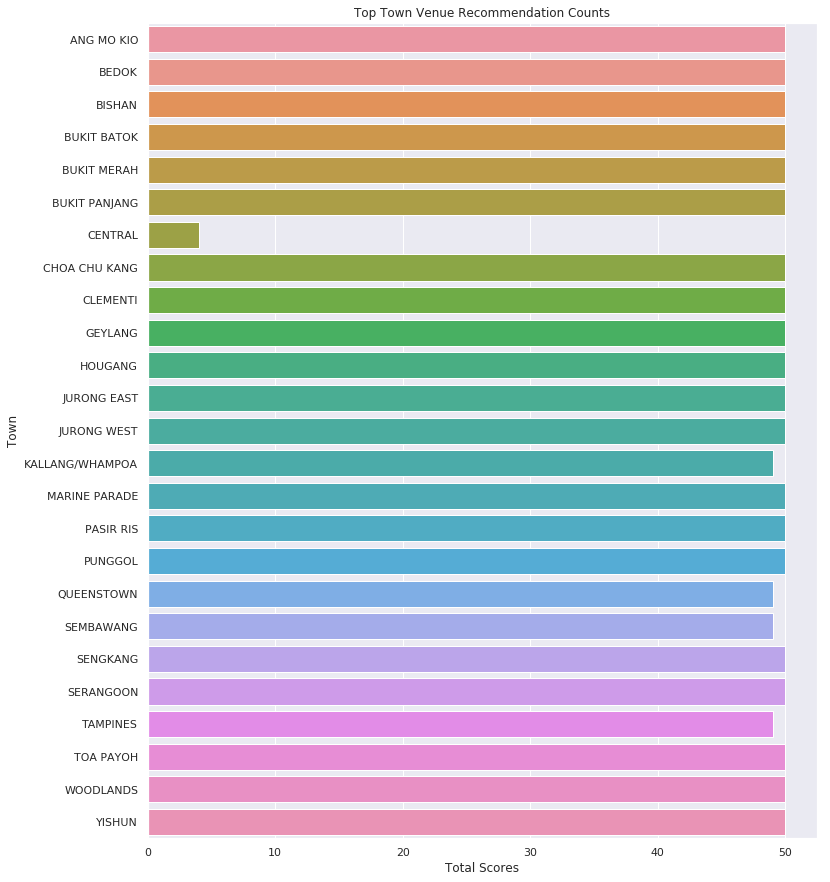

In [303]:
sns.set(rc={'figure.figsize':(12,15)})
ax = sns.barplot(data = venue_counts.reset_index(), x = 'score', y = 'Town')
ax.set_title("Top Town Venue Recommendation Counts")
ax.set_xlabel('Total Scores')
plt.show()

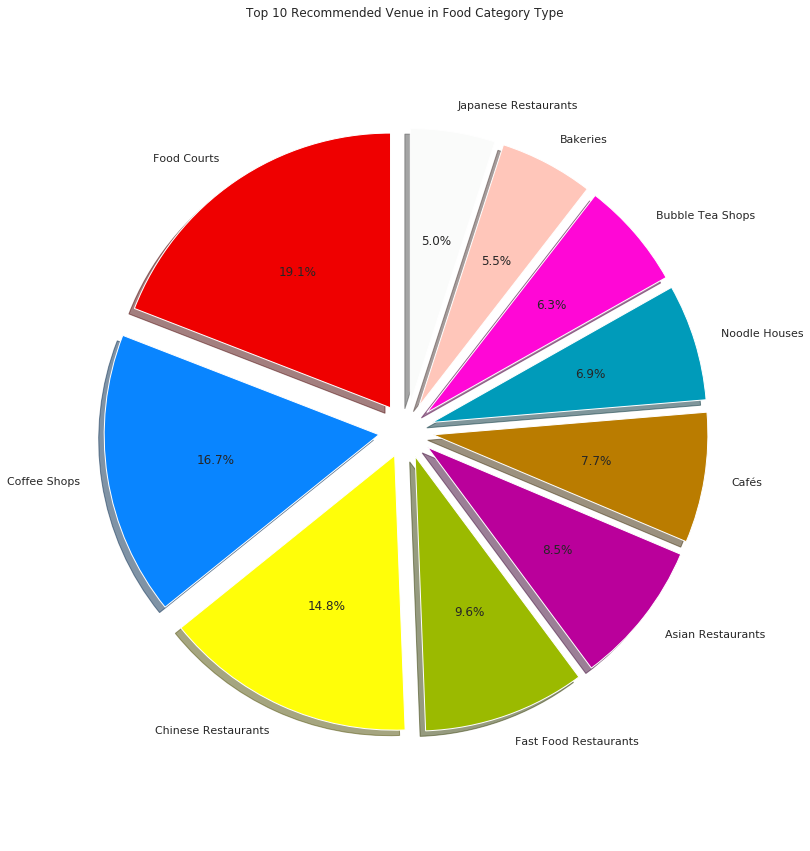

,category,VenueName
0,Food Courts,142
1,Coffee Shops,124
2,Chinese Restaurants,110
3,Fast Food Restaurants,71
4,Asian Restaurants,63
5,Cafés,57
6,Noodle Houses,51
7,Bubble Tea Shops,47
8,Bakeries,41
9,Japanese Restaurants,37


In [304]:
top_10_venue = singapore_town_venues.groupby('category')['VenueName'].count().sort_values(ascending=False)[:10].reset_index()
labels = top_10_venue['category']
sizes  = top_10_venue['VenueName']
colors = ['#ef0000','#0985ff','#fffe09','#9bba00','#ba009b','#ba7c00','#009bba','#ff07d6','#ffc6ba','#fafbfa']
explode = [.1] * 10
# Plot
plt.title("Top 10 Recommended Venue in Food Category Type")
ax1 = plt.pie(sizes, explode=explode, labels=labels, shadow=True,autopct='%1.1f%%', colors = colors,startangle=90)

plt.axis('equal')
plt.show()
top_10_venue

In [305]:
# Verify the dtypes 
singapore_town_venues.dtypes

Town               object
Town Latitude     float64
Town Longitude    float64
VenueID            object
VenueName          object
score              object
category           object
catID              object
latitude          float64
longitude         float64
dtype: object

#### How many unique categories can be curated from all the returned venues?

In [306]:
# Count number of categories that can be curated.
print('There are {} uniques categories.'.format(len(singapore_town_venues['category'].unique())))

There are 85 uniques categories.


#### What are the top 20 most common venue types?

In [307]:
# Check top 10 most frequently occuring venue type
singapore_town_venues.groupby('category')['VenueName'].count().sort_values(ascending=False)[:20]

category
Food Courts              142
Coffee Shops             124
Chinese Restaurants      110
Fast Food Restaurants     71
Asian Restaurants         63
Cafés                     57
Noodle Houses             51
Bubble Tea Shops          47
Bakeries                  41
Japanese Restaurants      37
Sushi Restaurants         31
Dessert Shops             29
Thai Restaurants          25
Steakhouses               20
Fried Chicken Joints      19
Italian Restaurants       18
Snack Places              16
Soup Places               15
Seafood Restaurants       15
Indian Restaurants        13
Name: VenueName, dtype: int64

## Analyze Each Singapore Town nearby recommended venues

In [308]:
# one hot encoding
sg_onehot = pd.get_dummies(singapore_town_venues[['category']], prefix="", prefix_sep="")

# add Town column back to dataframe
sg_onehot['Town'] = singapore_town_venues['Town'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

# Check returned one hot encoding data:
print('One hot encoding returned "{}" rows.'.format(sg_onehot.shape[0]))

# Regroup rows by town and mean of frequency occurrence per category.
sg_grouped = sg_onehot.groupby('Town').mean().reset_index()

print('One hot encoding re-group returned "{}" rows.'.format(sg_grouped.shape[0]))
sg_grouped.head()

One hot encoding returned "1200" rows.
One hot encoding re-group returned "25" rows.


,Town,American Restaurants,Asian Restaurants,BBQ Joints,Bakeries,Bistros,Breakfast Spots,Bubble Tea Shops,Buffets,Burger Joints,...,Steakhouses,Sushi Restaurants,Swiss Restaurants,Szechuan Restaurants,Taiwanese Restaurants,Tea Rooms,Thai Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wings Joints
0,ANG MO KIO,0.0,0.06,0.0,0.02,0.0,0.02,0.10,0.0,0.00,...,0.02,0.02,0.0,0.00,0.0,0.0,0.02,0.00,0.0,0.00
1,BEDOK,0.0,0.02,0.0,0.02,0.0,0.02,0.02,0.0,0.02,...,0.00,0.04,0.0,0.02,0.0,0.0,0.06,0.00,0.0,0.02
2,BISHAN,0.0,0.00,0.0,0.00,0.0,0.00,0.08,0.0,0.00,...,0.02,0.02,0.0,0.00,0.0,0.0,0.02,0.02,0.0,0.00
3,BUKIT BATOK,0.0,0.08,0.0,0.04,0.0,0.00,0.02,0.0,0.00,...,0.00,0.02,0.0,0.00,0.0,0.0,0.02,0.04,0.0,0.00
4,BUKIT MERAH,0.0,0.12,0.0,0.04,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00


## Analyze Singapore Town most visited venues

In [309]:
num_top_venues = 10
for town in sg_grouped['Town']:
    print("# Town=< "+town+" >")
    temp = sg_grouped[sg_grouped['Town'] == town].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

# Town=< ANG MO KIO >
                   venue  freq
0            Food Courts  0.16
1  Fast Food Restaurants  0.10
2       Bubble Tea Shops  0.10
3      Asian Restaurants  0.06
4           Coffee Shops  0.06
5          Noodle Houses  0.06
6      Malay Restaurants  0.04
7                 Diners  0.04
8          Dessert Shops  0.04
9    Chinese Restaurants  0.04


# Town=< BEDOK >
                   venue  freq
0           Coffee Shops  0.16
1            Food Courts  0.10
2    Chinese Restaurants  0.08
3                  Cafés  0.06
4       Thai Restaurants  0.06
5   Japanese Restaurants  0.06
6        Ice Cream Shops  0.04
7   Fried Chicken Joints  0.04
8      Halal Restaurants  0.04
9  Fast Food Restaurants  0.04


# Town=< BISHAN >
                   venue  freq
0            Food Courts  0.16
1           Coffee Shops  0.14
2    Chinese Restaurants  0.12
3  Fast Food Restaurants  0.10
4       Bubble Tea Shops  0.08
5                  Cafés  0.06
6        Ice Cream Shops  0.04
7   Japan

First, let's write a function to sort the venues in descending order.

In [310]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [311]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
town_venues_sorted = pd.DataFrame(columns=columns)
town_venues_sorted['Town'] = sg_grouped['Town']

for ind in np.arange(sg_grouped.shape[0]):
    town_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

print(town_venues_sorted.shape)
town_venues_sorted.head()

(25, 11)


,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANG MO KIO,Food Courts,Bubble Tea Shops,Fast Food Restaurants,Noodle Houses,Asian Restaurants,Coffee Shops,Chinese Restaurants,Malay Restaurants,Dessert Shops,Diners
1,BEDOK,Coffee Shops,Food Courts,Chinese Restaurants,Cafés,Japanese Restaurants,Thai Restaurants,Sushi Restaurants,Noodle Houses,Fast Food Restaurants,Fried Chicken Joints
2,BISHAN,Food Courts,Coffee Shops,Chinese Restaurants,Fast Food Restaurants,Bubble Tea Shops,Cafés,Ice Cream Shops,Japanese Restaurants,Noodle Houses,Hotpot Restaurants
3,BUKIT BATOK,Food Courts,Chinese Restaurants,Asian Restaurants,Coffee Shops,Vegetarian / Vegan Restaurants,Bakeries,Fast Food Restaurants,Frozen Yogurt Shops,Fish & Chips Shops,Ice Cream Shops
4,BUKIT MERAH,Cafés,Coffee Shops,Asian Restaurants,Chinese Restaurants,Food Courts,Japanese Restaurants,Noodle Houses,Bakeries,Snack Places,Cupcake Shops


In [320]:
town_venues_sorted['Town']

0          ANG MO KIO
1               BEDOK
2              BISHAN
3         BUKIT BATOK
4         BUKIT MERAH
5       BUKIT PANJANG
6             CENTRAL
7       CHOA CHU KANG
8            CLEMENTI
9             GEYLANG
10            HOUGANG
11        JURONG EAST
12        JURONG WEST
13    KALLANG/WHAMPOA
14      MARINE PARADE
15          PASIR RIS
16            PUNGGOL
17         QUEENSTOWN
18          SEMBAWANG
19           SENGKANG
20          SERANGOON
21           TAMPINES
22          TOA PAYOH
23          WOODLANDS
24             YISHUN
Name: Town, dtype: object

In [321]:
singapore_average_rental_prices_by_town = singapore_average_rental_prices_by_town[singapore_average_rental_prices_by_town['Town'] != 'BUKIT TIMAH']

In [322]:
singapore_average_rental_prices_by_town.shape

(25, 4)

## Clustering Neighborhoods
Run *k*-means to cluster the Towns into 5 clusters.

In [323]:
# set number of clusters
kclusters = 5
sg_grouped_clustering = sg_grouped.drop('Town', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])
print(len(kmeans.labels_))

[0 1 1 1 3 2 4 2 1 3]
25


In [324]:
town_venues_sorted.head()

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANG MO KIO,Food Courts,Bubble Tea Shops,Fast Food Restaurants,Noodle Houses,Asian Restaurants,Coffee Shops,Chinese Restaurants,Malay Restaurants,Dessert Shops,Diners
1,BEDOK,Coffee Shops,Food Courts,Chinese Restaurants,Cafés,Japanese Restaurants,Thai Restaurants,Sushi Restaurants,Noodle Houses,Fast Food Restaurants,Fried Chicken Joints
2,BISHAN,Food Courts,Coffee Shops,Chinese Restaurants,Fast Food Restaurants,Bubble Tea Shops,Cafés,Ice Cream Shops,Japanese Restaurants,Noodle Houses,Hotpot Restaurants
3,BUKIT BATOK,Food Courts,Chinese Restaurants,Asian Restaurants,Coffee Shops,Vegetarian / Vegan Restaurants,Bakeries,Fast Food Restaurants,Frozen Yogurt Shops,Fish & Chips Shops,Ice Cream Shops
4,BUKIT MERAH,Cafés,Coffee Shops,Asian Restaurants,Chinese Restaurants,Food Courts,Japanese Restaurants,Noodle Houses,Bakeries,Snack Places,Cupcake Shops


In [325]:
kmeans.labels_

array([0, 1, 1, 1, 3, 2, 4, 2, 1, 3, 2, 1, 0, 3, 2, 0, 2, 3, 0, 2, 2, 3,
       1, 2, 0], dtype=int32)

In [326]:
town_venues_sorted = town_venues_sorted.set_index("Town")
sg_merged = singapore_average_rental_prices_by_town.set_index("Town")
#sg_merged = town_venues_sorted.set_index("Town")
# add clustering labels
sg_merged['Cluster Labels'] = kmeans.labels_
# merge sg_grouped with singapore_average_rental_prices_by_town to add latitude/longitude for each neighborhood
sg_merged = sg_merged.join(town_venues_sorted)
sg_merged

,median_rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Town,,,,,,,,,,,,,,
ANG MO KIO,1957.195122,1.370073,103.849516,0,Food Courts,Bubble Tea Shops,Fast Food Restaurants,Noodle Houses,Asian Restaurants,Coffee Shops,Chinese Restaurants,Malay Restaurants,Dessert Shops,Diners
BEDOK,1958.211055,1.323976,103.930216,1,Coffee Shops,Food Courts,Chinese Restaurants,Cafés,Japanese Restaurants,Thai Restaurants,Sushi Restaurants,Noodle Houses,Fast Food Restaurants,Fried Chicken Joints
BISHAN,2118.773006,1.351452,103.848250,1,Food Courts,Coffee Shops,Chinese Restaurants,Fast Food Restaurants,Bubble Tea Shops,Cafés,Ice Cream Shops,Japanese Restaurants,Noodle Houses,Hotpot Restaurants
BUKIT BATOK,1922.827225,1.349057,103.749591,1,Food Courts,Chinese Restaurants,Asian Restaurants,Coffee Shops,Vegetarian / Vegan Restaurants,Bakeries,Fast Food Restaurants,Frozen Yogurt Shops,Fish & Chips Shops,Ice Cream Shops
BUKIT MERAH,2257.237288,1.280628,103.830591,3,Cafés,Coffee Shops,Asian Restaurants,Chinese Restaurants,Food Courts,Japanese Restaurants,Noodle Houses,Bakeries,Snack Places,Cupcake Shops
BUKIT PANJANG,1852.586207,1.378629,103.762136,2,Asian Restaurants,American Restaurants,Sushi Restaurants,Fast Food Restaurants,Coffee Shops,Italian Restaurants,Food Courts,Noodle Houses,Japanese Restaurants,Cafés
CENTRAL,2400.706522,1.340863,103.830392,4,Cafés,Coffee Shops,Tea Rooms,Restaurants,Wings Joints,Donut Shops,Dumpling Restaurants,Eastern European Restaurants,English Restaurants,Falafel Restaurants
CHOA CHU KANG,1902.500000,1.384749,103.744534,2,Coffee Shops,Noodle Houses,Cafés,Chinese Restaurants,Food Courts,Restaurants,Fast Food Restaurants,Bakeries,Dessert Shops,Bubble Tea Shops
CLEMENTI,2111.664516,1.315100,103.765231,1,Food Courts,Coffee Shops,Chinese Restaurants,Asian Restaurants,Sushi Restaurants,Steakhouses,Fried Chicken Joints,Bubble Tea Shops,Fast Food Restaurants,Chinese Breakfast Places


In [327]:
# Save town cluster collection. 
# This list is already interesting data for display in different webpages.
fileName = "sg_top_clusters.csv"
linkName = "Singapore_" + fileName
create_download_link(sg_merged,linkName,fileName)

In [329]:
import matplotlib.colors as colors

In [330]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles="Openstreetmap", zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged.index.values,kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## V. Conclusion

In this notebook, we've analyzed the best town venues and provided recommendations based on Best Food venue category. 

As singapore is a small country with a wide variety of interesting venues scattered around the town, the information extracted in this notebook present on the town areas, as this will be a good supplement to web based recommendations for visitors to find out nearby venues of interest and will be a useful aid in deciding a place to stay or where to go during their travel.

We used Foursquare API and collected a good amount of venue recommnedations in Singapore Towns. Sourcing from the venue recommendations from FourSquare has its limitation, The list of venues is not an exhaustive list of all the available venues is the area but covered a good amount of important venues. Also, not all the venues found in the the area were provided with store ratings. For this reason, the number of analyzed venues are only about 50% of all the available venues initially collected. The results therefore may significantly change, when more information are collected on those with missing data. 

The generated clusters from our results shows that there are very good and interesting places located in areas where the median rents are cheaper. This kind of results may be very interesting for travelers who are travelling on a limited budget. Our results also yielded some interesting findings. For instance, The initial assumption among websites providing recommendations is that the Central Area that have the highest median rent also have better food venues. The results however shows that while Marine Parade, a cheaper location has better rated food courts. Result shows that most popular food venue among Singaporeans, residents and visitors are **Food Courts, Coffee Shops, Chinese Restaurants and Fast Food Restaurants**.


Thank you.
